# Team 24 Group Project Proposal

Date: March 6th 2021

Authors: Kian Da Costa, Jack He, Dani Fookes, Ethan Tse


## Introduction:

For students, balancing life and school can be challenging, and achieving a balance between leisure and studying is often critical to a good academic standing. 

Here, we propose using a K nearest neighbors Classification (KNN)-model to explore the relationship between time spent on several common distractions and grades received in school.

The dataset we will be using for this analysis was collected by Paulo Cortez from the University of Minho, GuimarÃ£es, Portugal. This dataset details the performance of students aged 15-22 from two Portugeuse secondary schools. Each row represents an observation of a single student, with the grades they received from each period (G1, G2, G3) along with various details of their life, such as how much free time they have, whether they are in a romantic relationship etc.

# Load Relevant Libraries

In [1]:
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(repr)
set.seed(1000)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

# Data Collection

First we read the data into a workable form.

In [47]:
#Idea from: https://stackoverflow.com/questions/3053833/using-r-to-download-zipped-data-file-extract-and-import-data

#Data from: https://archive.ics.uci.edu/ml/machine-learning-databases/00320/ 
#and https://archive.ics.uci.edu/ml/datasets/Student+Performance


#make a temporary file 
tempfile <- tempfile()

#download file into temp 
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip", 
              tempfile) 

#extract relevant files 
student_mat <- read.table(unz(tempfile, "student-mat.csv"), 
                          header = TRUE, 
                          sep = ";")
student_por <- read.table(unz(tempfile, "student-por.csv"), 
                          header = TRUE, 
                          sep = ";")
unlink(tempfile)

#read files to see
head(student_mat, 5)
head(student_por, 5)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
2,GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
3,GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
4,GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,2,15,14,15
5,GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,4,6,10,10


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,4,0,11,11
2,GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,2,9,11,11
3,GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,6,12,13,12
4,GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,0,14,14,14
5,GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,0,11,13,13


Table 1. The first 5 rows of the 2 datasets we will be using: Students in a math class and students in a portugese class.

## Tidying the data/Splitting into training and testing sets
For the remaining code in this notebooks, we will be working on the __training data__ only 

Here, we merge the two datasets to include grades for both Math and Portugese

In [52]:
#Merge the datasets
total_set <- rbind(student_mat, student_por) 

#filter for desired columns
filtered_set <- total_set %>% 
                select(goout, Dalc, Walc, G3)

#reduce the number of classes our model needs to predict by grouping final grades (G3)
#here, we use the portugese grading system found at: https://www.scholaro.com/pro/Countries/Portugal/Grading-System
#this website shows the portugese grades on a 1-20 scale to letter grades on the American Grading System
data_train_new_classifier <- filtered_set %>% 
    mutate(G3_class = case_when((G3 >= 0 & G3 <= 6.99) ~ "F",
                                (G3 >= 7 & G3 <= 9.99) ~"D",
                                (G3 >= 10 & G3 <= 13.99) ~ "C",
                                (G3 >= 14 & G3 <= 15.99) ~ "B", 
                                (G3 >= 16 & G3 <= 17.99) ~ "A",
                                (G3 >= 18 & G3 <= 20 ~ "A+")),
          G3_class = as.factor(G3_class)) 

head(data_train_new_classifier, 10)
unique(data_train_new_classifier$G3_class)

#split our dataset into a training and testing set.
data_split <- initial_split(data_train_new_classifier, prop = 0.75, strata = G3)  #where G3 = final grade
data_train <- training(data_split)   
data_test <- testing(data_split)
head(data_train, 4)

,goout,Dalc,Walc,G3,G3_class
,<int>,<int>,<int>,<int>,<fct>
1,4,1,1,6,F
2,3,1,1,6,F
3,2,2,3,10,C
4,2,1,1,15,B
5,2,1,2,10,C
6,2,1,2,15,B
7,4,1,1,11,C
8,4,1,1,6,F
9,2,1,1,19,A+


[1] F  C  B  A+ D  A 
Levels: A A+ B C D F

,goout,Dalc,Walc,G3,G3_class
,<int>,<int>,<int>,<int>,<fct>
1,4,1,1,6,F
2,3,1,1,6,F
4,2,1,1,15,B
5,2,1,2,10,C


# Exploratory Data Analysis: 

## Average Rate of the three predictor variables 

In [53]:
#Find the mean of our predictor variables goout, Dalc, Walc
predictor_means <- data_train %>%
                   select(goout, Dalc, Walc) %>%
                   map_df(mean)
predictor_means

goout,Dalc,Walc
<dbl>,<dbl>,<dbl>
3.173248,1.48535,2.28535


We can see that on average more people go out with their friends versus drinking alcohol on the weekdays or weekends. It will be interesting to see if this variable has a greater effect on students' grades versus alcohol consumption.

## Visualization: 

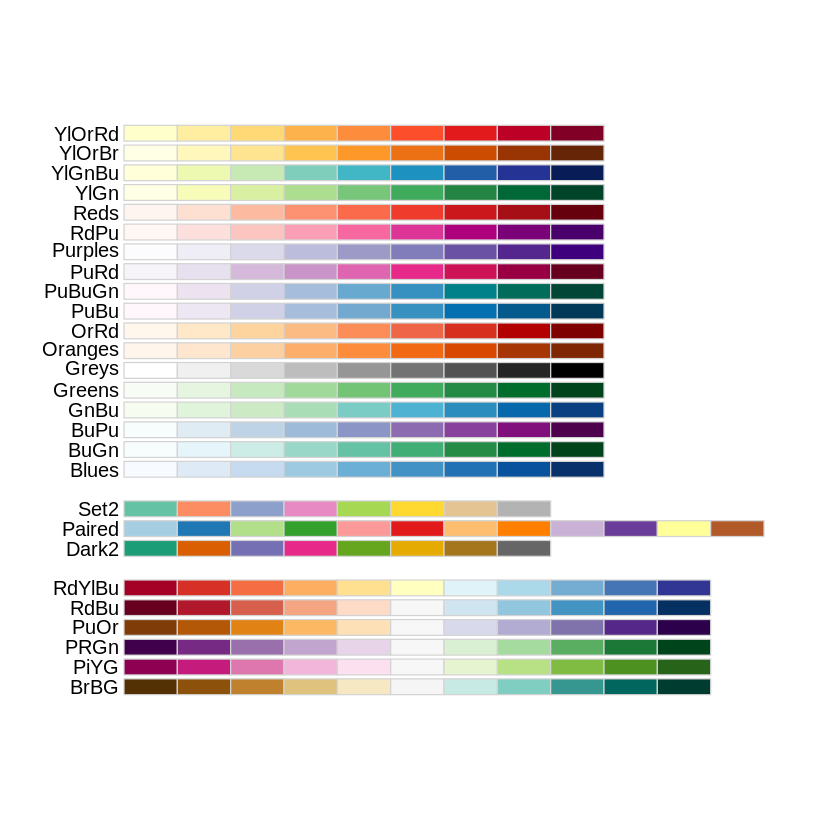

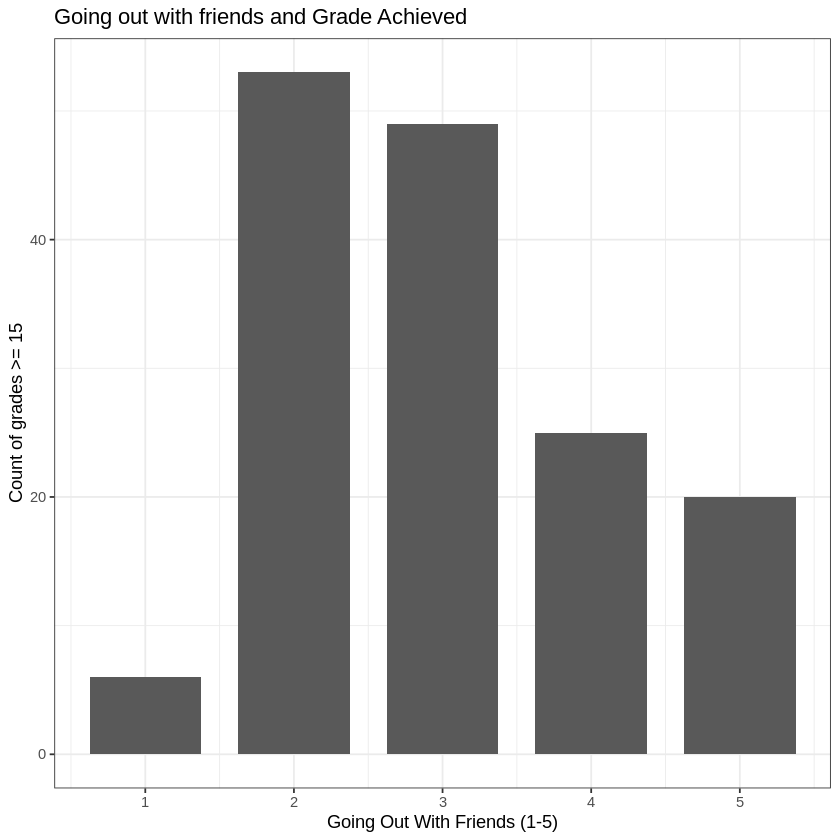

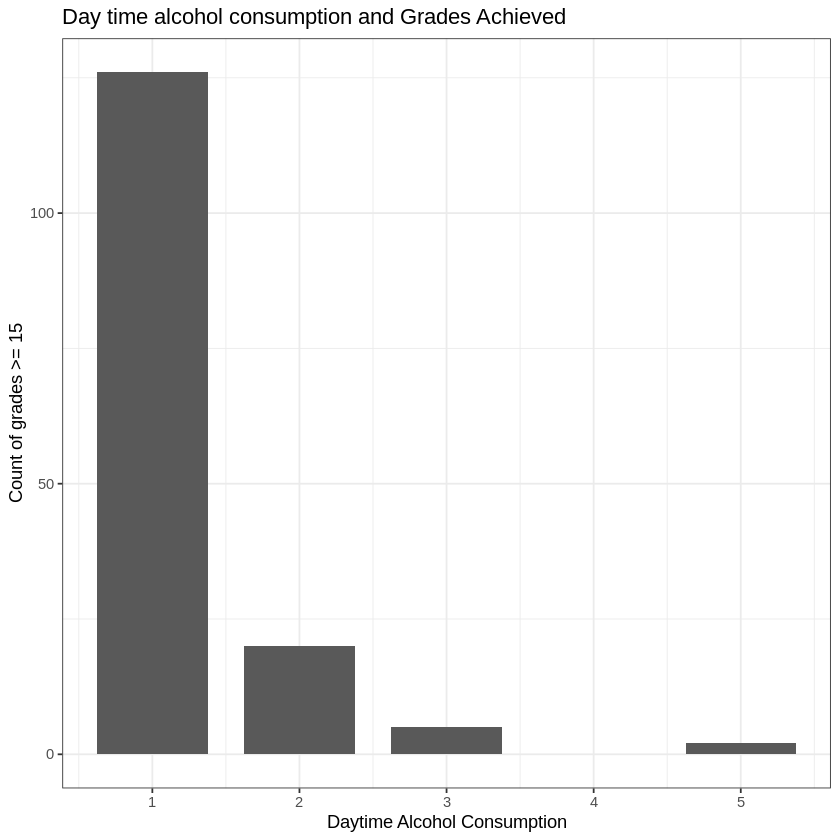

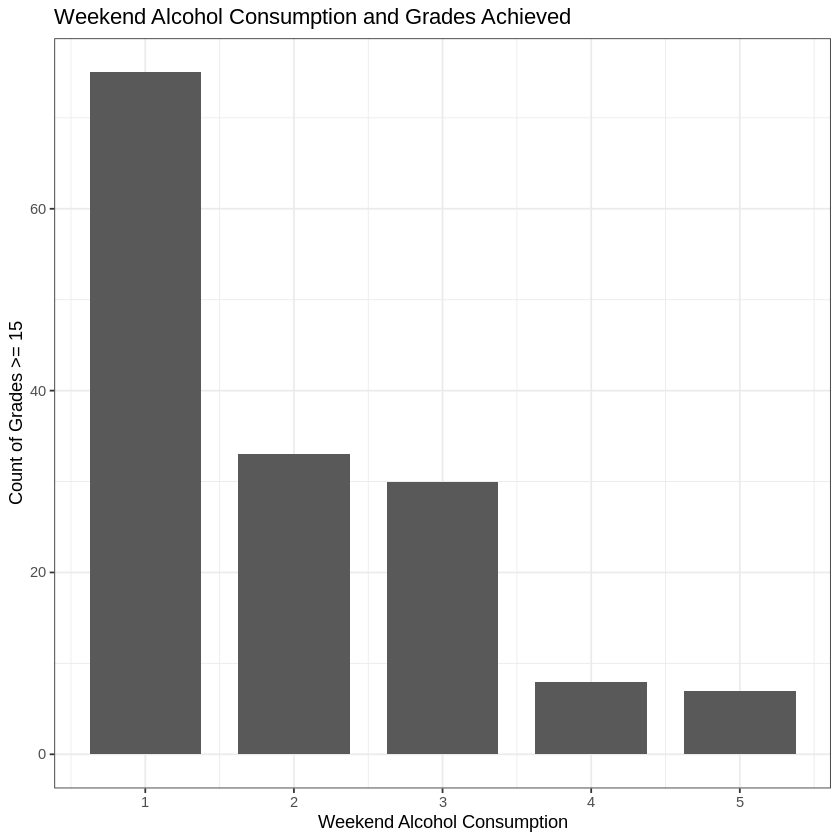

In [54]:
#plots that display the count of how many people got good grades (G3 >= 15) for each predictor variable

#Add Colour Scheme 
#View RColorBrewer possible palettes 
display.brewer.all(colorblindFriendly = T)

goout_viz <- data_train %>%
    filter(G3 >= 15) %>%
    ggplot(aes(x = goout)) +
    geom_bar(width = 0.75) +
    labs(x = "Going Out With Friends (1-5)", 
        y = "Count of grades >= 15") + 
    ggtitle("Going out with friends and Grade Achieved") + 
    theme_bw()
    
dalc_viz <- data_train %>%
    filter(G3 >= 15) %>%
    ggplot(aes(x = Dalc)) +
    geom_bar(width = 0.75) +
    labs(x = "Daytime Alcohol Consumption", 
        y = "Count of grades >= 15") + 
    ggtitle("Day time alcohol consumption and Grades Achieved") + 
    theme_bw()
walc_viz <- data_train %>%
    filter(G3 >= 15) %>%
    ggplot(aes(x = Walc)) +
    geom_bar(width = 0.75) +
    labs(x = "Weekend Alcohol Consumption", 
        y = "Count of Grades >= 15") + 
    ggtitle("Weekend Alcohol Consumption and Grades Achieved") + 
    theme_bw()
goout_viz
dalc_viz
walc_viz

We can see that there is a clear trend with alcohol consumption - students who drink more alcohol tend to not get good grades. However, the trend is not as clear with the "going out with friends" variable. 

# SEPARATOR ---------------------------------------------------------------------------------------

# Results 

## K Nearest Neighbours Classification

Using this data, we wish to create a classifier that may be usable by school staff to predict the letter grades students will fall into based on their daytime/weekend alcohol consumption as well as the time they spend out with friends. 

## Step 1: Data Preprocessing 


In [55]:
#first see if the number of observations for each class is similar, otherwise the model will not be properly trained. 

#Here, we need to split a new set of data. This time, using G3_class as the strata

G3_class_split <- initial_split(data_with_lg, prop = 0.75, strata = G3_class)
G3_class_data_train <- training(G3_class_split)   
G3_class_data_test <- testing(G3_class_split)
head(G3_class_data_train, 4)

instances_for_classes <- data_train %>%  
    select(G3) %>%  
    group_by(G3) %>%  
    summarize(n = n(),
            percentage = n() / nrow(data_train) * 100)

instances_for_classes

,goout,Dalc,Walc,G3,G3_class
,<int>,<int>,<int>,<int>,<fct>
1,4,1,1,6,F
2,3,1,1,6,F
3,2,2,3,10,C
4,2,1,1,15,B


`summarise()` ungrouping output (override with `.groups` argument)



G3,n,percentage
<int>,<int>,<dbl>
0,42,5.3503185
4,1,0.1273885
5,6,0.7643312
6,13,1.6560510
7,14,1.7834395
8,52,6.6242038
9,45,5.7324841
10,115,14.6496815
11,114,14.5222930


Here, we can see from the summary table the number of observations for each class. Since there is a class imbalance, we would need to __balance__ the labels. 

Here, we check to see the distribution of the letter grades


In [56]:
#Add summary to check if class imbalance is present. 
class_imbalance_summary <- G3_class_data_train %>% 
    select(G3_class) %>% 
    group_by(G3_class) %>% 
    summarize(n = n(),
              percentage = n() / nrow(G3_class_data_train) * 100)

class_imbalance_summary

`summarise()` ungrouping output (override with `.groups` argument)



G3_class,n,percentage
<fct>,<int>,<dbl>
A,63,8.035714
A+,24,3.061224
B,133,16.964286
C,389,49.617347
D,115,14.668367
F,60,7.653061


Here, we can see from the summary table the number of observations for each class. Since there is a class imbalance, we would need to __balance__ the labels. We can do this using __step_upsample__ in the recipe. 

Next, we can check the range of our predictor values. If they are not on scales that are meaningfully different, we will need to scale them. 

In [58]:
#Check scales of the predictor variables 

predictor_scales <- data_train %>%  
    select(-G3, -G3_class) %>% 
    map_df(range) #using map_df to iterate over columns. 

predictor_scales

goout,Dalc,Walc
<int>,<int>,<int>
1,1,1
5,5,5


From this analysis, we can see that goout, Dalc, Walc are on on the same scale. Thus, scaling is not explicitly needed here. For completeness, however, we will scale as practice. 

In [59]:
set.seed(1000)

#Create recipe 
#lg = letter grade

data_train_no_grade <- G3_class_data_train %>%  
    select(-G3)

nrow(data_train_no_grade)

#To work around an error induced by step_upsample, we will first upsample the data_train_new_classifier dataframe. 
upsample_recipe <- recipe(G3_class ~ Walc + Dalc, 
                          data = data_train_no_grade) %>% 
    step_upsample(G3_class, over_ratio = 1, skip = FALSE) %>% 
    prep()

#Here, we upscale the dataframe by applying the recipe to unedited dataframe
upsampled_data_train_no_grade <- bake(upsample_recipe, 
                                      data_train_no_grade)

#Here, we create another recipe to be used in the workflow. We use the upsampled dataframe.
lg_classifier_recipe <- recipe(G3_class ~ Walc + Dalc, 
                              data = upsampled_data_train_no_grade) %>% 
    step_scale(all_predictors()) %>%  
    step_center(all_predictors()) 


#Further split data for CROSS-VALIDATION to select a suitable K
#data_train_new_classifier has 785 observations. For completeness, we can try using v = 10 for 10 fold cross-validation
lg_data_cv <- data_train_no_grade %>% 
    vfold_cv(v = 10, strata = G3_class)

#                 QUESTION! DO WE USE THE UPSAMPLED DATA HERE? OR ORIGINAL TRAINING DATA
#when i use the upsampled one, all K's give roughly the same accuracy (0.25)


#Create model specification 
lg_classifier_knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", 
                                          neighbors = tune()) %>%  
    set_engine("kknn") %>% 
    set_mode("classification") 

gridvals <- tibble(neighbors = seq(1:40))

#Create workflow for cross validation 
cv_workflow <- workflow() %>% 
    add_recipe(lg_classifier_recipe) %>%  
    add_model(lg_classifier_knn_spec_tune) %>%  
    tune_grid(resamples = lg_data_cv, 
              grid = gridvals)

cv_metrics <- cv_workflow %>%  
    collect_metrics() %>% 
    filter(.metric == "accuracy")

head(cv_metrics)
tail(cv_metrics)

[1] 784

! Fold01: internal: No observations were detected in `truth` for level(s): 'A+'
Co...



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.2107114,10,0.01660527,Model01
2,accuracy,multiclass,0.2337721,10,0.01915165,Model02
3,accuracy,multiclass,0.2463678,10,0.01543765,Model03
4,accuracy,multiclass,0.2592208,10,0.01649311,Model04
5,accuracy,multiclass,0.2605028,10,0.01292057,Model05
6,accuracy,multiclass,0.2758237,10,0.01611558,Model06


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
35,accuracy,multiclass,0.4871789,10,0.011579879,Model35
36,accuracy,multiclass,0.4961532,10,0.007824708,Model36
37,accuracy,multiclass,0.4961532,10,0.007824708,Model37
38,accuracy,multiclass,0.4961532,10,0.007824708,Model38
39,accuracy,multiclass,0.4788693,10,0.019206645,Model39
40,accuracy,multiclass,0.4788693,10,0.019206645,Model40


Table X. As can be seen, the accuracy estimates are very low. This may indicate that our predictors may not be the most suitable for our classifier. 

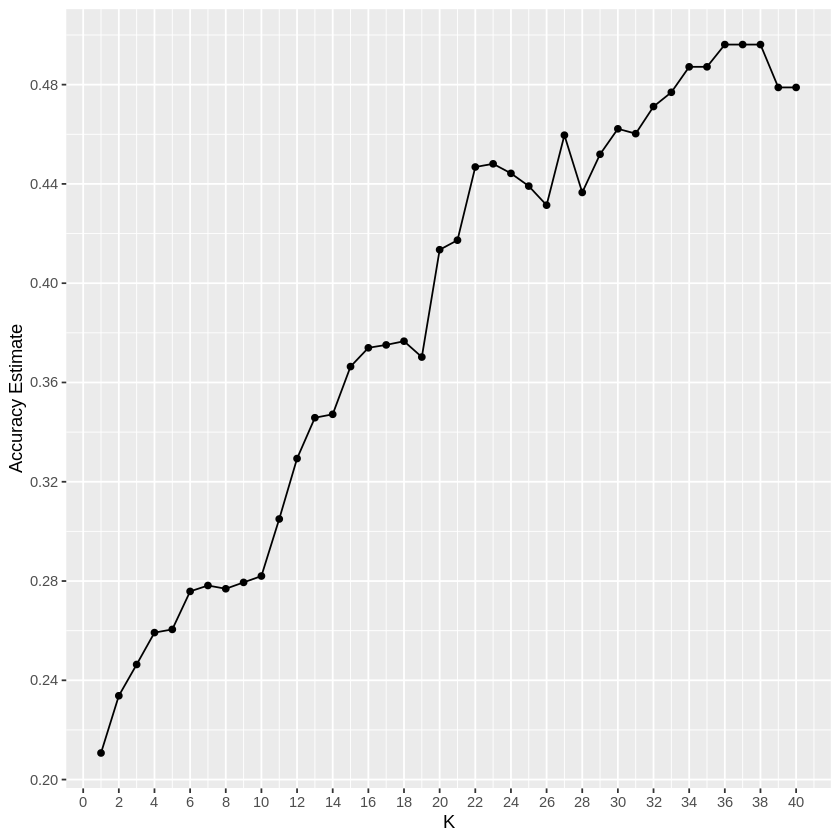

In [60]:
#Visualize the K
k_plot <- cv_metrics %>% 
    select(neighbors, mean) %>% 
    ggplot(aes(x = neighbors, 
              y = mean)) + 
    geom_point() + 
    geom_line() +
    labs(x = "K", 
         y = "Accuracy Estimate") + 
    scale_x_continuous(n.breaks = 20) + 
    scale_y_continuous(n.breaks = 10)

k_plot

Figure X. Plotting K versus Accuracy shows that the optimal K value would be 21. However, it is important to note that the accuarcy estimate is very low (~0.5), which indicates that our predictors may not be very accurate. 

In [61]:
#Complete and create a KNN-Classifier 

#Specify a new KNN Classification Model, this time with the selected K value = 16 
lg_classifier_knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", 
                                                neighbors = 21) %>% 
    set_engine("kknn") %>% 
    set_mode("classification") 

#Create a fit
#we can reuse the recipe from the cross-validation 
lg_classifier_knn_fit <- workflow() %>% 
    add_recipe(lg_classifier_recipe) %>%  
    add_model(lg_classifier_knn_spec_tuned) %>% 
    fit(data = data_train_no_grade)

#                 QUESTION! DO WE USE THE UPSAMPLED DATA HERE? OR ORIGINAL TRAINING DATA

#using the workflow, make predictions 
lg_predictions <- lg_classifier_knn_fit %>% 
    predict(G3_class_data_test) %>% 
    bind_cols(G3_class_data_test)

head(lg_predictions)

lg_prediction_metrics <- lg_predictions %>% 
    metrics(truth = G3_class, 
           estimate = .pred_class) 

#extract numerical value of accuracy
lg_predictor_accuracy <- lg_prediction_metrics %>% 
    filter(.metric == "accuracy") %>% 
    select(.estimate) %>% 
    pull()

lg_predictor_accuracy

.pred_class,goout,Dalc,Walc,G3,G3_class
<fct>,<int>,<int>,<int>,<int>,<fct>
C,4,1,1,11,C
C,2,1,1,12,C
C,3,1,3,14,B
C,2,1,1,16,A
C,5,2,4,5,F
C,3,1,3,10,C


[1] 0.5038462

Here, we can see that the accuracy of our predictor, based on the predictors: walc, and dalc, is quite poor, sitting at ~50% accurate. In the real world, this predictor would not be very useful for teachers to use as a way of predicting final student grades. 

To see if we can come up with an accurate predictor, perhaps we can try to use KNN regression. This can be used for using quantitative variables to predict quantitative, which is the type of data we have. 

# K Nearest Neighbours __Regression__

In [62]:
set.seed(1000)

#Here, we will be predicting G3, a quantitative final grade. 
#For simplicity, we will try to predict with one variable: Dalc 
data_train_no_class <- data_train %>%  
    select(-G3_class)

nrow(data_train_no_class)

#   QUESTION: do you need to upscale for KNN regression?

# upsample_train_regression_recipe <- recipe(G3 ~ Walc + Dalc, 
#                                      data = data_train_no_class) %>% 
#     step_upsample(G3, over_ratio = 1, skip = FALSE) %>% 
#     prep()

# upsample_train_regression_data <- bake(upsample_train_regression_recipe, 
#                                        data_train_no_class)


#Here, we create another recipe to be used in the workflow. We use the upsampled dataframe as the same with the Classifier. 
lg_regression_recipe <- recipe(G3 ~ Dalc, 
                              data = data_train_no_class) %>% 
    step_scale(all_predictors()) %>%  
    step_center(all_predictors()) 

#Specify the model specification with tuning 
lg_knn_regression_spec <- nearest_neighbor(weight_func = "rectangular", 
                                        neighbors = tune()) %>%  
    set_engine("kknn") %>%  
    set_mode("regression") 

#Cross validate to find best K 
lg_knn_regression_cv <- vfold_cv(data_train_no_class, v = 10, strata = G3)

knn_metrics_regression <- workflow() %>%  
  add_recipe(lg_regression_recipe) %>%  
  add_model(lg_knn_regression_spec) %>%  
  tune_grid(resamples = lg_knn_regression_cv, 
            grid = gridvals) %>%  
  collect_metrics() 

head(knn_metrics_regression) 
tail(knn_metrics_regression)

least_rmse <- knn_metrics_regression %>%  
    filter(.metric == "rmse") %>%  
    filter(mean == min(mean)) 

#Give K = 38
least_rmse

knn_reg_spec_final <- nearest_neighbor(weight_func = "rectangular", 
                                        neighbors = 38) %>%  
    set_engine("kknn") %>%  
    set_mode("regression") 

#Assemble a new workflow 
knn_reg_fit <- workflow() %>%  
    add_recipe(lg_regression_recipe) %>%  
    add_model(knn_reg_spec_final) %>%  
    fit(data = data_train_no_class) 

predictions <- knn_reg_fit %>%  
    predict(data_test) %>%  
    bind_cols(data_test) 

metrics <- predictions %>%
  metrics(truth = G3, 
          estimate = .pred) 

metrics


[1] 785

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,6.39926725,10,0.094463717,Model01
1,rsq,standard,0.01338498,10,0.005667182,Model01
2,rmse,standard,6.04125787,10,0.160388145,Model02
2,rsq,standard,0.02541299,10,0.008783825,Model02
3,rmse,standard,4.57382513,10,0.123153007,Model03
3,rsq,standard,0.02369996,10,0.009832862,Model03


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
38,rmse,standard,3.88855936,10,0.134619589,Model38
38,rsq,standard,0.02839605,10,0.009359636,Model38
39,rmse,standard,3.89015824,10,0.133279101,Model39
39,rsq,standard,0.02713729,10,0.008696991,Model39
40,rmse,standard,3.89043865,10,0.133626201,Model40
40,rsq,standard,0.02805827,10,0.009161794,Model40


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
38,rmse,standard,3.888559,10,0.1346196,Model38


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.79063491
rsq,standard,0.02409349
mae,standard,2.87969925


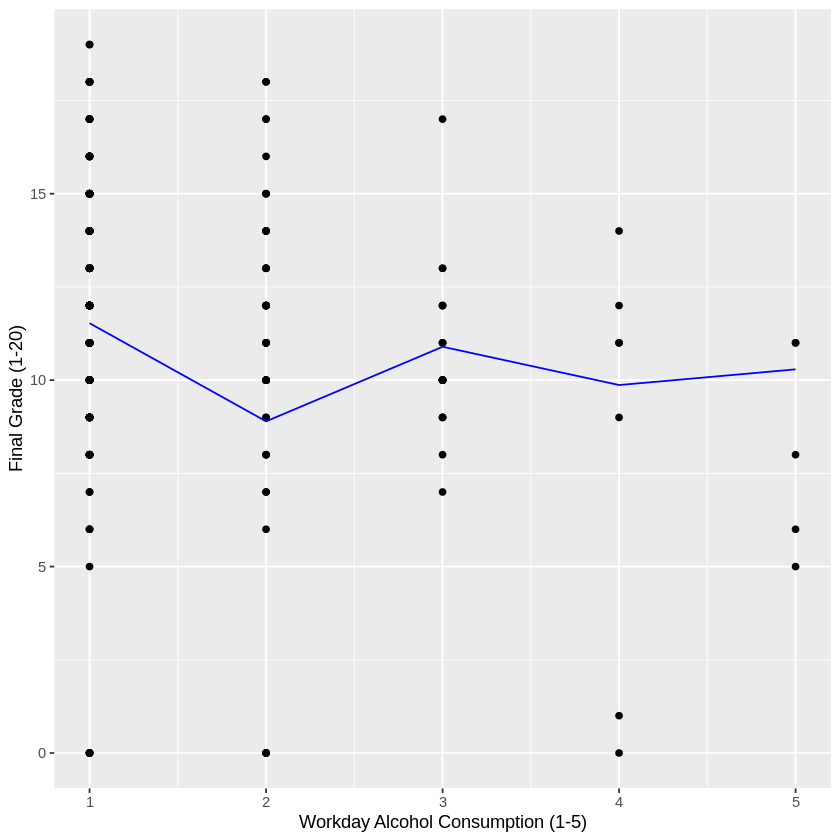

In [63]:
#Plot the KNN regression
plot_final <- predictions %>%  
    ggplot(aes(x = Dalc, 
               y = G3)) + 
    geom_point() + 
    labs(x = "Workday Alcohol Consumption (1-5)", 
         y = "Final Grade (1-20)") + 
    geom_line(data = predictions, 
              aes(x = Dalc, 
                  y = .pred), 
              colour = "blue")

plot_final


From this, it is clear that there is no linear relationship between final grade and Weekend Alcohol Consumption

# K Means Clustering 